# Descrição

In [1]:
!pip install --quiet segmentation-models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.1 MB/s eta 0:00:00


In [2]:
#obtendo diretorio da base
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
from google.colab import files

Mounted at /content/gdrive


In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [4]:
#Descompactar arquivo e salvar imagens (X) e CSV (LABELS)
import zipfile
import os
path_to_dataset = '/content/gdrive/MyDrive/Doutorado/Bases/GAMMA_training_data/multi-modality_images/Retinografias_Mascaras/dataset_fundus.zip'

def descompactar_arquivo(zip_path, destino):
    """Descompacta um arquivo .zip e salva em uma pasta específica."""
    if not os.path.exists(destino):
        os.makedirs(destino)  # Cria a pasta de destino se não existir

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(destino)
        print(f"Arquivos extraídos para: {destino}")

# Exemplo de uso
zip_path = path_to_dataset  # Substitua pelo caminho do seu arquivo .zip
destino = "/content/Dataset GAMMA 2"  # Substitua pelo caminho onde deseja salvar os arquivos

descompactar_arquivo(zip_path, destino)

Arquivos extraídos para: /content/Dataset GAMMA 2


In [5]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Configurar Segmentation Models para usar TensorFlow Keras
sm.set_framework('tf.keras')

# Diretórios das imagens e máscaras
IMAGE_DIR = "/content/Dataset GAMMA 2/GAMMA_Fundus_Images"
MASK_DIR = "/content/Dataset GAMMA 2/Disc_Cup_Mask"

# Tamanho das imagens
IMG_SIZE = (256, 256)  # Ajuste conforme necessário
BATCH_SIZE = 4
EPOCHS = 100
BACKBONE = 'resnet50'

# Garantir que os diretórios existem
if not os.path.exists(IMAGE_DIR) or not os.path.exists(MASK_DIR):
    raise FileNotFoundError("Diretório de imagens ou máscaras não encontrado!")

# Carregar as imagens e máscaras
def load_images_and_masks(image_dir, mask_dir, img_size):
    images, masks = [], []
    image_filenames = sorted(os.listdir(image_dir))
    mask_filenames = sorted(os.listdir(mask_dir))

    # Criar um dicionário para acessar máscaras pelo nome da imagem sem a extensão
    mask_dict = {os.path.splitext(f)[0]: f for f in mask_filenames}

    for img_name in image_filenames:
        img_base_name = os.path.splitext(img_name)[0]  # Nome do arquivo sem extensão

        # Verificar se existe uma máscara correspondente
        if img_base_name not in mask_dict:
            continue

        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_dict[img_base_name])

        # Carregar e processar a imagem
        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, img_size) / 255.0  # Normalização

        # Carregar e processar a máscara
        mask = cv2.imread(mask_path)
        if mask is None:
            continue
        mask = np.where(mask==128, 1, mask)#converte a cor cinza (disk) em preto (cup) --> Agora teremos apenas uma classe.
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)  # Melhor para segmentação
        mask = (np.expand_dims(mask, axis=-1) / 255.0).astype(np.float32)  # Normalização
        mask = np.round(mask)
        #mask = mask / 255.0  # Normalização

        images.append(image)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Carregar os dados
images, masks = load_images_and_masks(IMAGE_DIR, MASK_DIR, IMG_SIZE)

In [7]:
# Dividir os dados em treino, validação e teste
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Pré-processamento do backbone
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

# Criar modelo U-Net com ResNet50 como backbone
model = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), classes=1, activation='sigmoid')

# Compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=sm.losses.binary_focal_dice_loss,
    metrics=[sm.metrics.iou_score]
)

# Adicionar callbacks para melhorar o treinamento
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

# Treinar o modelo
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

94592056/94592056 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 80s 816ms/step - iou_score: 0.4882 - loss: 0.4074 - val_iou_score: 0.3951 - val_loss: 0.5333 - learning_rate: 1.0000e-04
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - iou_score: 0.5884 - loss: 0.2908 - val_iou_score: 0.4584 - val_loss: 0.4303 - learning_rate: 1.0000e-04
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - iou_score: 0.6586 - loss: 0.2235 - val_iou_score: 0.5307 - val_loss: 0.3422 - learning_rate: 1.0000e-04
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - iou_score: 0.6948 - loss: 0.1916 - val_iou_score: 0.5549 - val_loss: 0.3166 - learning_rate: 1.0000e-04
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - iou_score: 0.7223 - loss: 0.1694 - val_iou_score: 0.5729 - val_loss: 0.2986 - learning_rate: 1.0000e-04
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - iou_score: 0.7446 - loss: 0.1530 - val_iou_score: 0.6073 - val_loss: 0.2659 - learning_rate: 1.000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - iou_score: 0.9881 - loss: 0.0069
Test IOU Score: 0.9881
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
[0 1]
[0 1]
[0 1]


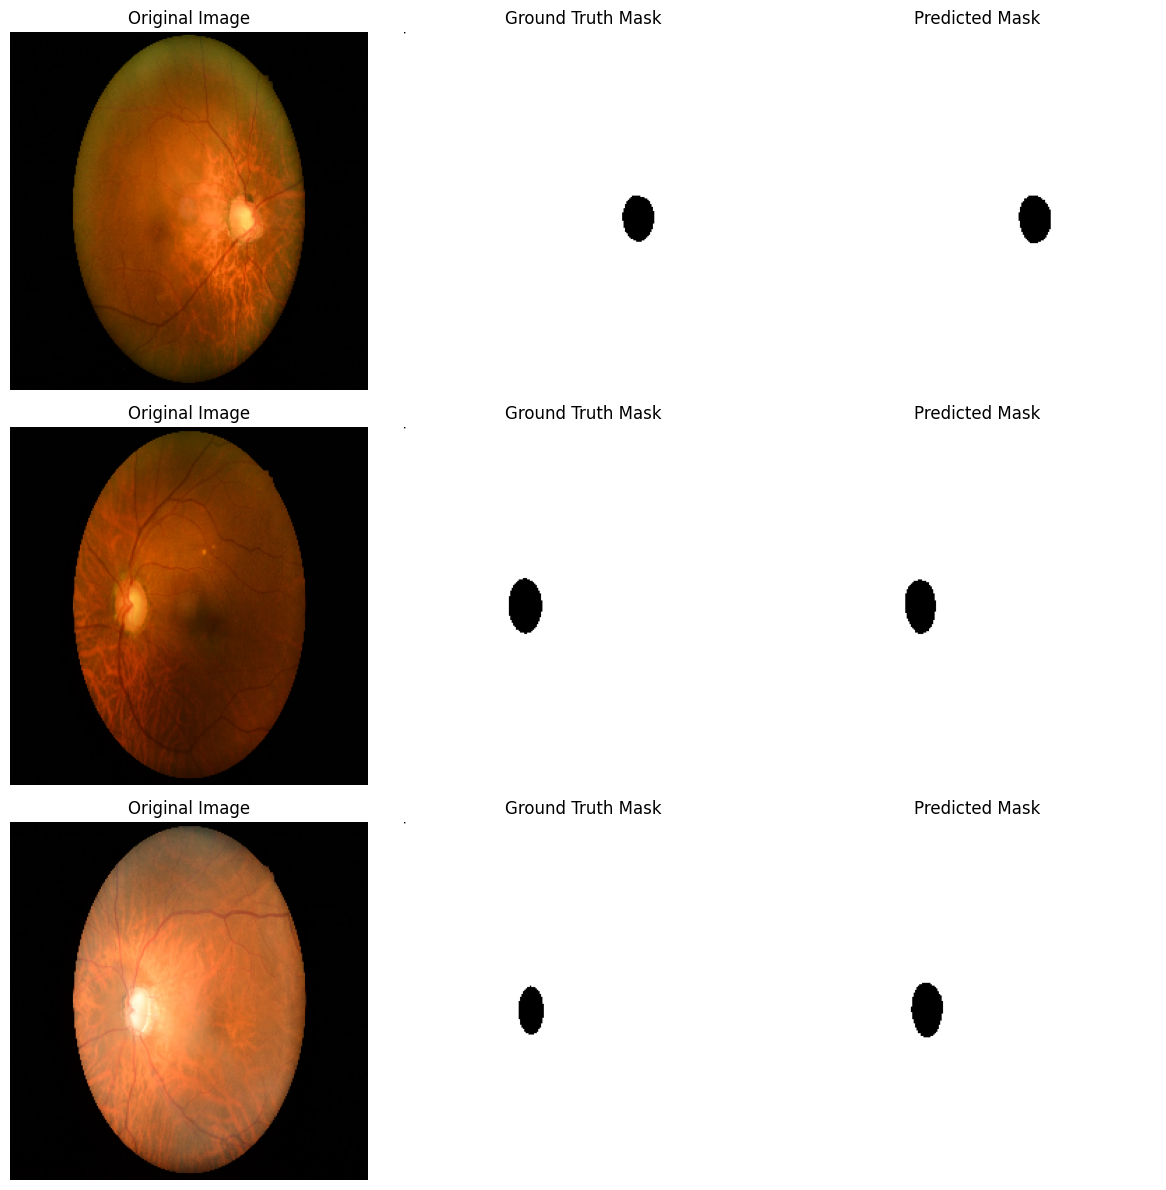

In [9]:
# Avaliar no conjunto de teste
test_results = model.evaluate(X_test, y_test)
print(f"Test IOU Score: {test_results[1]:.4f}")

# Função para exibir imagens e previsões
def plot_predictions(model, images, masks, num_samples=3):
    preds = model.predict(images[:num_samples])
    #preds = (preds <= 0.5).astype(np.float32)
    preds = (preds > 0.5).astype(np.uint8)
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))

    for i in range(num_samples):
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(masks[i].squeeze(), cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(preds[i].squeeze(), cmap="gray")
        axes[i, 2].set_title("Predicted Mask")
        axes[i, 2].axis("off")
        print(np.unique(preds[i]))

    plt.tight_layout()
    plt.show()

# Exibir previsões
plot_predictions(model, X_test, y_test)